# exp24: アカウント獲得数予測 + Optuna最適化（Holdout Validation）

**目的変数**: `acc_get_cnt`（翌日のアカウント獲得数）

**背景**:
- exp22/23では入電数（call_num）を予測
- アカウント獲得数も重要なKPIであり、予測モデルを構築

**実験内容**:
1. アカウント獲得数用の特徴量設計
2. Optunaで各モデルを最適化
3. Holdout Validationで評価

**使用モデル**:
- Ridge
- ExtraTrees
- HistGradientBoosting
- CatBoost
- WeightedEnsemble

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')
import os

# 出力ディレクトリ
output_dir = '../output/exp24'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print('exp24: アカウント獲得数予測')

exp24: アカウント獲得数予測


In [2]:
# ==================================================================================
# データの読み込み
# ==================================================================================

def load_and_preprocess_data():
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    # アカウント獲得数をベースにする
    df = acc_get.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(call_data, on='cdr_date', how='left')
    
    # Google Trendsを週次→日次に展開
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

print('データ読み込み関数を定義しました')

データ読み込み関数を定義しました


In [3]:
# ==================================================================================
# 特徴量作成関数（アカウント獲得数予測用）
# ==================================================================================

def create_basic_time_features(df):
    """基本的な時系列特徴量"""
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_acc_lag_features(df, target_col='acc_get_cnt', lags=[1, 2, 3, 5, 7, 14, 30]):
    """アカウント獲得数のラグ特徴量"""
    df = df.copy()
    for lag in lags:
        df[f'acc_lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_acc_rolling_features(df, target_col='acc_get_cnt', windows=[3, 7, 14, 30]):
    """アカウント獲得数の移動統計量"""
    df = df.copy()
    for window in windows:
        df[f'acc_ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'acc_ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_call_features(df):
    """入電数関連の特徴量（アカ獲との関連を捉える）"""
    df = df.copy()
    # 入電数のラグ
    df['call_lag_1'] = df['call_num'].shift(1)
    df['call_lag_7'] = df['call_num'].shift(7)
    # 入電数の移動平均
    df['call_ma_7'] = df['call_num'].shift(1).rolling(window=7, min_periods=1).mean()
    df['call_ma_14'] = df['call_num'].shift(1).rolling(window=14, min_periods=1).mean()
    return df

def create_aggregated_features(df):
    """集約特徴量"""
    df = df.copy()
    # CM効果の累積
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['cm_14d'] = df['cm_flg'].shift(1).rolling(window=14, min_periods=1).sum()
    # Google Trendsの移動平均
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['gt_ma_14'] = df['search_cnt'].shift(1).rolling(window=14, min_periods=1).mean()
    # 曜日ごとの過去平均
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'acc_get_cnt'].shift(1).expanding().mean()
    return df

def create_regime_change_features(df):
    """レジーム変化特徴量（消費税増税など）"""
    df = df.copy()
    
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    # 駆け込み需要期間
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    # 適応期間
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    return df

print('特徴量作成関数を定義しました')

特徴量作成関数を定義しました


In [4]:
# ==================================================================================
# データ準備
# ==================================================================================

print("*" * 80)
print("exp24: アカウント獲得数予測 + Optuna最適化")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)

print(f"\n統合後データ: {df.shape}")
print(f"期間: {df['cdr_date'].min()} ~ {df['cdr_date'].max()}")

# 特徴量作成
df = create_basic_time_features(df)
df = create_acc_lag_features(df)
df = create_acc_rolling_features(df)
df = create_call_features(df)
df = create_aggregated_features(df)
df = create_regime_change_features(df)

# 翌日のアカウント獲得数を目的変数にする
df['target_next_day'] = df['acc_get_cnt'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ（土日はアカ獲が少ない傾向があるため）
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")

********************************************************************************
exp24: アカウント獲得数予測 + Optuna最適化
********************************************************************************

統合後データ: (701, 14)
期間: 2018-05-01 00:00:00 ~ 2020-03-31 00:00:00

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [5]:
# ==================================================================================
# 特徴量の定義
# ==================================================================================

feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'year', 
    'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'search_cnt',
    # 入電数関連
    'call_num', 'call_lag_1', 'call_lag_7', 'call_ma_7', 'call_ma_14',
    # アカウント獲得数ラグ
    'acc_lag_1', 'acc_lag_2', 'acc_lag_3', 'acc_lag_5', 'acc_lag_7', 'acc_lag_14', 'acc_lag_30',
    # アカウント獲得数移動平均
    'acc_ma_3', 'acc_ma_7', 'acc_ma_14', 'acc_ma_30',
    'acc_ma_std_3', 'acc_ma_std_7', 'acc_ma_std_14', 'acc_ma_std_30',
    # 集約特徴量
    'cm_7d', 'cm_14d', 'gt_ma_7', 'gt_ma_14', 'dow_avg',
    # レジーム変化特徴量
    'days_to_2019_10_01', 'is_post_2019_10_01',
    'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
]

print(f"使用する特徴量数: {len(feature_cols)}")
print("\n【特徴量一覧】")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feat}")

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()
print(f"\n欠損値除去後: {len(df_clean)}行")

使用する特徴量数: 40

【特徴量一覧】
   1. dow
   2. day_of_month
   3. year
   4. day_of_year
   5. week_of_year
   6. is_month_start
   7. is_month_end
   8. day_before_holiday_flag
   9. cm_flg
  10. search_cnt
  11. call_num
  12. call_lag_1
  13. call_lag_7
  14. call_ma_7
  15. call_ma_14
  16. acc_lag_1
  17. acc_lag_2
  18. acc_lag_3
  19. acc_lag_5
  20. acc_lag_7
  21. acc_lag_14
  22. acc_lag_30
  23. acc_ma_3
  24. acc_ma_7
  25. acc_ma_14
  26. acc_ma_30
  27. acc_ma_std_3
  28. acc_ma_std_7
  29. acc_ma_std_14
  30. acc_ma_std_30
  31. cm_7d
  32. cm_14d
  33. gt_ma_7
  34. gt_ma_14
  35. dow_avg
  36. days_to_2019_10_01
  37. is_post_2019_10_01
  38. is_post_2019_09_30
  39. is_rush_period
  40. is_adaptation_period

欠損値除去後: 472行


In [6]:
# ==================================================================================
# Holdout Validation 設定
# ==================================================================================

print("\n" + "=" * 80)
print("Holdout Validation 設定")
print("=" * 80)

# Holdout分割（exp22と同じ期間）
test_start_date = pd.Timestamp('2020-01-30')
train_end_date = test_start_date - pd.Timedelta(days=1)

train_df = df_clean[df_clean['cdr_date'] <= train_end_date].copy()
test_df = df_clean[df_clean['cdr_date'] >= test_start_date].copy()

X_train = train_df[feature_cols]
y_train = train_df['target_next_day']
X_test = test_df[feature_cols]
y_test = test_df['target_next_day']

print(f"\nTrain: {len(X_train)}件 ({train_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {train_df['cdr_date'].max().strftime('%Y-%m-%d')})")
print(f"Test : {len(X_test)}件 ({test_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {test_df['cdr_date'].max().strftime('%Y-%m-%d')})")

# 目的変数の統計
print(f"\n【目的変数（翌日アカウント獲得数）の統計】")
print(f"  Train - 平均: {y_train.mean():.1f}, 標準偏差: {y_train.std():.1f}, 最小: {y_train.min():.0f}, 最大: {y_train.max():.0f}")
print(f"  Test  - 平均: {y_test.mean():.1f}, 標準偏差: {y_test.std():.1f}, 最小: {y_test.min():.0f}, 最大: {y_test.max():.0f}")


Holdout Validation 設定

Train: 429件 (2018-06-08 ~ 2020-01-29)
Test : 43件 (2020-01-30 ~ 2020-03-30)

【目的変数（翌日アカウント獲得数）の統計】
  Train - 平均: 0.2, 標準偏差: 1.0, 最小: -2, 最大: 6
  Test  - 平均: 0.0, 標準偏差: 0.4, 最小: -1, 最大: 1


In [7]:
# ==================================================================================
# 評価関数
# ==================================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    """Weighted Absolute Percentage Error"""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    """モデル評価指標を計算"""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


---

# Optunaによるハイパーパラメータ最適化

In [8]:
# ==================================================================================
# Optuna 設定
# ==================================================================================

import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor

optuna.logging.set_verbosity(optuna.logging.WARNING)

# TimeSeriesCV（3分割）
tscv = TimeSeriesSplit(n_splits=3)

print("\n" + "=" * 80)
print("Optunaによるハイパーパラメータ最適化")
print("=" * 80)
print("\n各モデル100トライアル、TimeSeriesCV(n_splits=3)で評価")


Optunaによるハイパーパラメータ最適化

各モデル100トライアル、TimeSeriesCV(n_splits=3)で評価


In [9]:
# ==================================================================================
# Ridge 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[1/4] Ridge 最適化")
print("-" * 60)

def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 0.01, 100.0, log=True)
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = Ridge(alpha=alpha, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_ridge = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_ridge.optimize(objective_ridge, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_ridge.best_value:.2f}")
print(f"Best params: {study_ridge.best_params}")


------------------------------------------------------------
[1/4] Ridge 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 0.42
Best params: {'alpha': 0.6626447325557159}


In [10]:
# ==================================================================================
# ExtraTrees 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[2/4] ExtraTrees 最適化")
print("-" * 60)

def objective_extra(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = ExtraTreesRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_extra = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_extra.optimize(objective_extra, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_extra.best_value:.2f}")
print(f"Best params: {study_extra.best_params}")


------------------------------------------------------------
[2/4] ExtraTrees 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 0.54
Best params: {'n_estimators': 554, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


In [11]:
# ==================================================================================
# HistGradientBoosting 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[3/4] HistGradientBoosting 最適化")
print("-" * 60)

def objective_hist(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.01, 50.0, log=True),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = HistGradientBoostingRegressor(**params, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_hist = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_hist.optimize(objective_hist, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_hist.best_value:.2f}")
print(f"Best params: {study_hist.best_params}")


------------------------------------------------------------
[3/4] HistGradientBoosting 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 0.49
Best params: {'max_iter': 545, 'learning_rate': 0.2791988542993881, 'max_depth': 25, 'min_samples_leaf': 16, 'l2_regularization': 0.37145188035339205}


In [12]:
# ==================================================================================
# CatBoost 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[4/4] CatBoost 最適化")
print("-" * 60)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = CatBoostRegressor(**params, random_state=42, verbose=0)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_catboost = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_catboost.optimize(objective_catboost, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_catboost.best_value:.2f}")
print(f"Best params: {study_catboost.best_params}")


------------------------------------------------------------
[4/4] CatBoost 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 0.48
Best params: {'iterations': 2779, 'learning_rate': 0.037468984919821244, 'depth': 4, 'l2_leaf_reg': 0.5570793012579085, 'subsample': 0.7070894694475385}


In [13]:
# ==================================================================================
# 最適化されたパラメータの保存
# ==================================================================================

OPTIMIZED_PARAMS_EXP24 = {
    'Ridge': study_ridge.best_params,
    'ExtraTrees': study_extra.best_params,
    'HistGradientBoosting': study_hist.best_params,
    'CatBoost': study_catboost.best_params,
}

print("\n" + "=" * 80)
print("exp24 最適化パラメータ")
print("=" * 80)
for model_name, params in OPTIMIZED_PARAMS_EXP24.items():
    print(f"\n{model_name}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

# パラメータをCSVに保存
params_list = []
for model_name, params in OPTIMIZED_PARAMS_EXP24.items():
    for key, value in params.items():
        params_list.append({'model': model_name, 'param': key, 'value': value})

params_df = pd.DataFrame(params_list)
params_df.to_csv(f'{output_dir}/optimized_params.csv', index=False)
print(f"\nパラメータを保存しました: {output_dir}/optimized_params.csv")


exp24 最適化パラメータ

Ridge:
  alpha: 0.6626447325557159

ExtraTrees:
  n_estimators: 554
  max_depth: 39
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2

HistGradientBoosting:
  max_iter: 545
  learning_rate: 0.2791988542993881
  max_depth: 25
  min_samples_leaf: 16
  l2_regularization: 0.37145188035339205

CatBoost:
  iterations: 2779
  learning_rate: 0.037468984919821244
  depth: 4
  l2_leaf_reg: 0.5570793012579085
  subsample: 0.7070894694475385

パラメータを保存しました: ../output/exp24/optimized_params.csv


---

# 最適化パラメータでの最終評価

In [14]:
# ==================================================================================
# 最適化パラメータでの最終評価
# ==================================================================================

print("\n" + "=" * 80)
print("最適化パラメータでの最終評価（Holdout Test）")
print("=" * 80)

final_results = []
final_predictions = {}
final_models = {}

# 1. Ridge
print("\n[1/4] Ridge...")
ridge_opt = Ridge(**OPTIMIZED_PARAMS_EXP24['Ridge'], random_state=42)
ridge_opt.fit(X_train, y_train)
ridge_pred_opt = ridge_opt.predict(X_test)
ridge_metrics_opt = evaluate_model(y_test, ridge_pred_opt)
print(f"  MAE: {ridge_metrics_opt['MAE']:.2f}, R2: {ridge_metrics_opt['R2']:.4f}")
final_predictions['Ridge'] = ridge_pred_opt
final_models['Ridge'] = ridge_opt
final_results.append({'model': 'Ridge', **ridge_metrics_opt})

# 2. ExtraTrees
print("\n[2/4] ExtraTrees...")
extra_opt = ExtraTreesRegressor(**OPTIMIZED_PARAMS_EXP24['ExtraTrees'], random_state=42, n_jobs=-1)
extra_opt.fit(X_train, y_train)
extra_pred_opt = extra_opt.predict(X_test)
extra_metrics_opt = evaluate_model(y_test, extra_pred_opt)
print(f"  MAE: {extra_metrics_opt['MAE']:.2f}, R2: {extra_metrics_opt['R2']:.4f}")
final_predictions['ExtraTrees'] = extra_pred_opt
final_models['ExtraTrees'] = extra_opt
final_results.append({'model': 'ExtraTrees', **extra_metrics_opt})

# 3. HistGradientBoosting
print("\n[3/4] HistGradientBoosting...")
hist_opt = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS_EXP24['HistGradientBoosting'], random_state=42)
hist_opt.fit(X_train, y_train)
hist_pred_opt = hist_opt.predict(X_test)
hist_metrics_opt = evaluate_model(y_test, hist_pred_opt)
print(f"  MAE: {hist_metrics_opt['MAE']:.2f}, R2: {hist_metrics_opt['R2']:.4f}")
final_predictions['HistGradientBoosting'] = hist_pred_opt
final_models['HistGradientBoosting'] = hist_opt
final_results.append({'model': 'HistGradientBoosting', **hist_metrics_opt})

# 4. CatBoost
print("\n[4/4] CatBoost...")
catboost_opt = CatBoostRegressor(**OPTIMIZED_PARAMS_EXP24['CatBoost'], random_state=42, verbose=0)
catboost_opt.fit(X_train, y_train)
catboost_pred_opt = catboost_opt.predict(X_test)
catboost_metrics_opt = evaluate_model(y_test, catboost_pred_opt)
print(f"  MAE: {catboost_metrics_opt['MAE']:.2f}, R2: {catboost_metrics_opt['R2']:.4f}")
final_predictions['CatBoost'] = catboost_pred_opt
final_models['CatBoost'] = catboost_opt
final_results.append({'model': 'CatBoost', **catboost_metrics_opt})

final_df = pd.DataFrame(final_results).sort_values('MAE')
print("\n" + "=" * 80)
print("最適化パラメータでの結果")
print("=" * 80)
print(final_df.to_string(index=False))


最適化パラメータでの最終評価（Holdout Test）

[1/4] Ridge...
  MAE: 0.21, R2: 0.5784

[2/4] ExtraTrees...
  MAE: 0.16, R2: 0.7312

[3/4] HistGradientBoosting...
  MAE: 0.16, R2: 0.6963

[4/4] CatBoost...
  MAE: 0.15, R2: 0.7081

最適化パラメータでの結果
               model      MAE     RMSE       R2      WAPE
            CatBoost 0.154442 0.214547 0.708075 48.039503
          ExtraTrees 0.157124 0.205886 0.731168 48.873862
HistGradientBoosting 0.161632 0.218814 0.696346 50.276087
               Ridge 0.209651 0.257835 0.578389 65.212657


In [15]:
# ==================================================================================
# Weighted Ensemble
# ==================================================================================

from scipy.optimize import minimize

print("\n" + "=" * 80)
print("Weighted Ensemble（Testセットで重み最適化）")
print("=" * 80)

def optimize_weights(predictions_dict, y_true, model_names):
    preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
    
    def objective(weights):
        ensemble_pred = preds_matrix @ weights
        return mean_absolute_error(y_true, ensemble_pred)
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    bounds = [(0, 1) for _ in range(len(model_names))]
    initial_weights = np.ones(len(model_names)) / len(model_names)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

ensemble_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
weights = optimize_weights(final_predictions, y_test, ensemble_models)

print("\n最適化された重み:")
for name, weight in zip(ensemble_models, weights):
    print(f"  {name}: {weight:.4f}")

ensemble_pred = np.column_stack([final_predictions[name] for name in ensemble_models]) @ weights
ensemble_metrics = evaluate_model(y_test, ensemble_pred)
print(f"\nWeightedEnsemble MAE: {ensemble_metrics['MAE']:.2f}, R2: {ensemble_metrics['R2']:.4f}")

final_results.append({'model': 'WeightedEnsemble', **ensemble_metrics})
final_predictions['WeightedEnsemble'] = ensemble_pred
final_df = pd.DataFrame(final_results).sort_values('MAE')


Weighted Ensemble（Testセットで重み最適化）

最適化された重み:
  Ridge: 0.0000
  CatBoost: 0.2926
  ExtraTrees: 0.4032
  HistGradientBoosting: 0.3042

WeightedEnsemble MAE: 0.14, R2: 0.7478


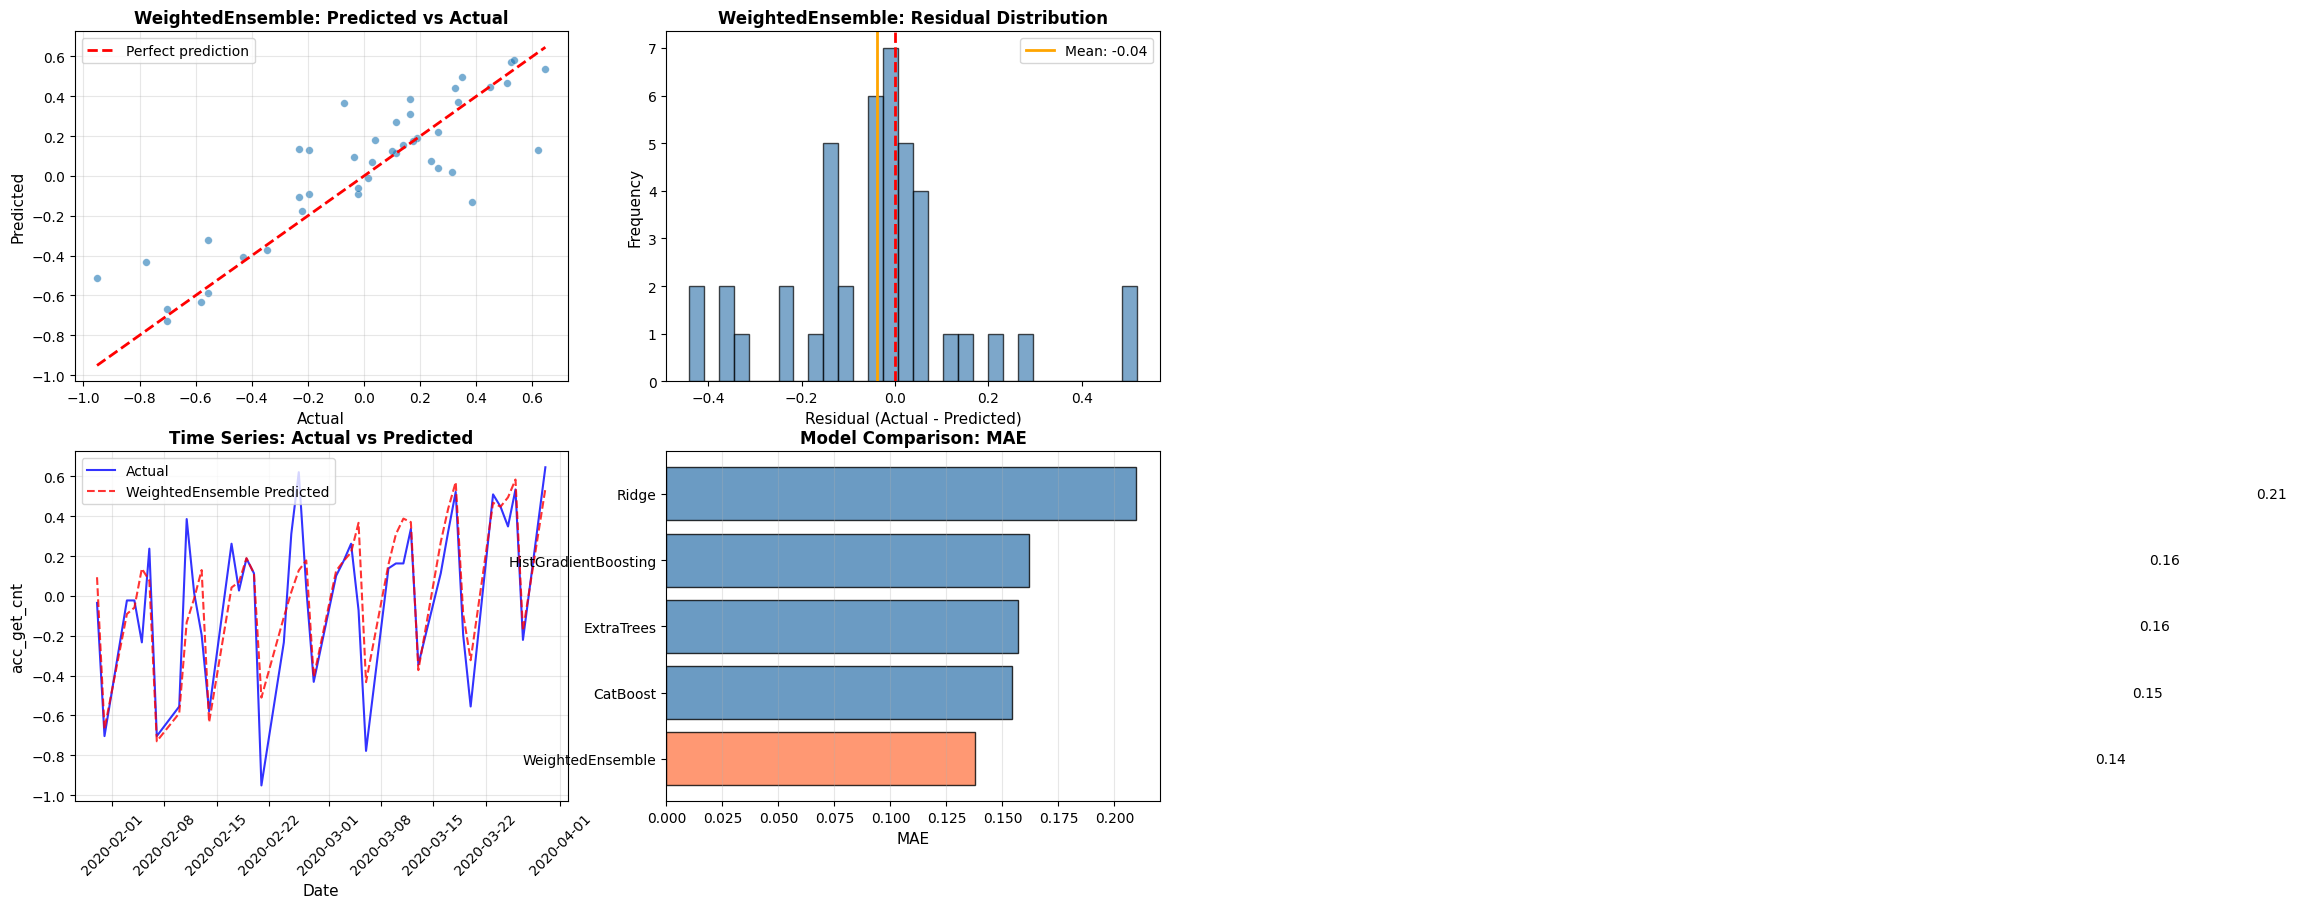


保存しました: ../output/exp24/prediction_results.png


In [16]:
# ==================================================================================
# 予測結果の可視化
# ==================================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 予測 vs 実績（散布図）
ax1 = axes[0, 0]
best_model = final_df.iloc[0]['model']
best_pred = final_predictions[best_model]
ax1.scatter(y_test, best_pred, alpha=0.6, s=30, edgecolor='white', linewidth=0.3)
min_val = min(y_test.min(), best_pred.min())
max_val = max(y_test.max(), best_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual', fontsize=11)
ax1.set_ylabel('Predicted', fontsize=11)
ax1.set_title(f'{best_model}: Predicted vs Actual', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. 残差分布
ax2 = axes[0, 1]
residuals = y_test.values - best_pred
ax2.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=residuals.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
ax2.set_xlabel('Residual (Actual - Predicted)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title(f'{best_model}: Residual Distribution', fontsize=12, fontweight='bold')
ax2.legend()

# 3. 時系列での予測推移
ax3 = axes[1, 0]
test_dates = test_df['cdr_date'].values
ax3.plot(test_dates, y_test.values, 'b-', label='Actual', linewidth=1.5, alpha=0.8)
ax3.plot(test_dates, best_pred, 'r--', label=f'{best_model} Predicted', linewidth=1.5, alpha=0.8)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('acc_get_cnt', fontsize=11)
ax3.set_title('Time Series: Actual vs Predicted', fontsize=12, fontweight='bold')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)
ax3.grid(alpha=0.3)

# 4. モデル別MAE比較
ax4 = axes[1, 1]
models = final_df['model'].tolist()
maes = final_df['MAE'].tolist()
colors = ['coral' if m == best_model else 'steelblue' for m in models]
bars = ax4.barh(models, maes, color=colors, edgecolor='black', alpha=0.8)
ax4.set_xlabel('MAE', fontsize=11)
ax4.set_title('Model Comparison: MAE', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, axis='x')
for bar, mae in zip(bars, maes):
    ax4.text(mae + 0.5, bar.get_y() + bar.get_height()/2, f'{mae:.2f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{output_dir}/prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n保存しました: {output_dir}/prediction_results.png")

In [17]:
# ==================================================================================
# 特徴量重要度分析
# ==================================================================================

from sklearn.inspection import permutation_importance

print("\n" + "=" * 80)
print("特徴量重要度分析")
print("=" * 80)

# 各モデルの特徴量重要度
importance_data = {}

# ExtraTrees
importance_data['ExtraTrees'] = extra_opt.feature_importances_

# CatBoost
importance_data['CatBoost'] = catboost_opt.feature_importances_

# HistGradientBoosting (permutation importance)
print("\nHistGradientBoostingのPermutation Importance計算中...")
perm_importance = permutation_importance(hist_opt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_data['HistGradientBoosting'] = perm_importance.importances_mean

# DataFrameにまとめる
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'ExtraTrees': importance_data['ExtraTrees'],
    'HistGradientBoosting': importance_data['HistGradientBoosting'],
    'CatBoost': importance_data['CatBoost']
})

# 各モデルの重要度を表示
for model_name in ['ExtraTrees', 'HistGradientBoosting', 'CatBoost']:
    print(f"\n【{model_name}】Top 10")
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=False).head(10)
    print(sorted_df.to_string(index=False))


特徴量重要度分析

HistGradientBoostingのPermutation Importance計算中...

【ExtraTrees】Top 10
                feature  ExtraTrees
         is_rush_period    0.090471
               acc_ma_7    0.070765
              acc_ma_14    0.059924
day_before_holiday_flag    0.051644
              acc_lag_5    0.045085
               acc_ma_3    0.038327
              acc_ma_30    0.036305
          acc_ma_std_14    0.035228
           acc_ma_std_3    0.033863
              acc_lag_1    0.033791

【HistGradientBoosting】Top 10
                feature  HistGradientBoosting
day_before_holiday_flag              1.272678
              acc_lag_3              0.062525
               acc_ma_7              0.055310
             acc_lag_30              0.022043
              acc_lag_2              0.021240
             search_cnt              0.015826
             call_lag_1              0.013944
           day_of_month              0.013535
                    dow              0.009054
          acc_ma_std_14          

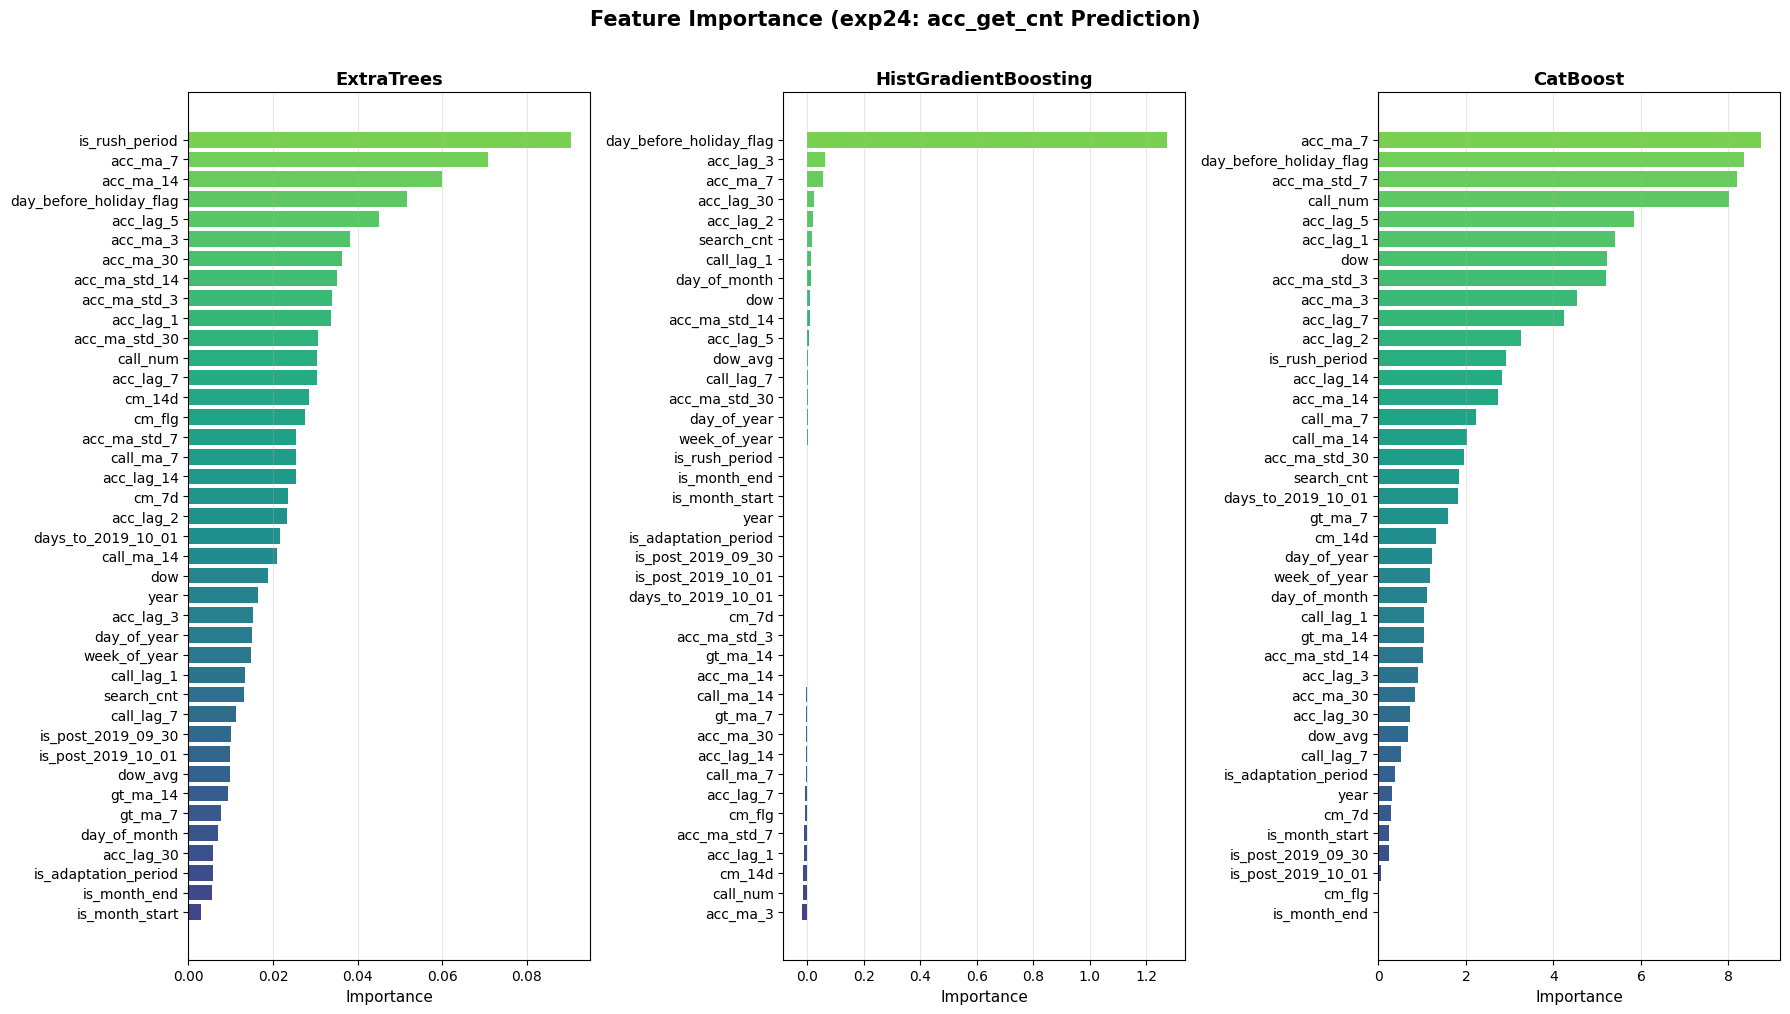


保存しました: ../output/exp24/feature_importance.csv


In [18]:
# ==================================================================================
# 特徴量重要度の可視化
# ==================================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for idx, model_name in enumerate(['ExtraTrees', 'HistGradientBoosting', 'CatBoost']):
    ax = axes[idx]
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=True)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_df)))
    ax.barh(sorted_df['feature'], sorted_df[model_name], color=colors)
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

plt.suptitle('Feature Importance (exp24: acc_get_cnt Prediction)', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

importance_df.to_csv(f'{output_dir}/feature_importance.csv', index=False)
print(f"\n保存しました: {output_dir}/feature_importance.csv")

In [19]:
# ==================================================================================
# 最終結果の保存
# ==================================================================================

final_df.to_csv(f'{output_dir}/final_results.csv', index=False)

# 予測結果も保存
prediction_df = test_df[['cdr_date', 'acc_get_cnt', 'target_next_day']].copy()
for model_name, pred in final_predictions.items():
    prediction_df[f'pred_{model_name}'] = pred
prediction_df.to_csv(f'{output_dir}/predictions.csv', index=False)

print("\n" + "=" * 80)
print("exp24 最終結果")
print("=" * 80)
print(final_df.to_string(index=False))

print(f"\n保存しました:")
print(f"  {output_dir}/final_results.csv")
print(f"  {output_dir}/predictions.csv")
print(f"  {output_dir}/optimized_params.csv")
print(f"  {output_dir}/feature_importance.csv")
print(f"  {output_dir}/prediction_results.png")
print(f"  {output_dir}/feature_importance.png")


exp24 最終結果
               model      MAE     RMSE       R2      WAPE
    WeightedEnsemble 0.137778 0.199432 0.747758 42.856216
            CatBoost 0.154442 0.214547 0.708075 48.039503
          ExtraTrees 0.157124 0.205886 0.731168 48.873862
HistGradientBoosting 0.161632 0.218814 0.696346 50.276087
               Ridge 0.209651 0.257835 0.578389 65.212657

保存しました:
  ../output/exp24/final_results.csv
  ../output/exp24/predictions.csv
  ../output/exp24/optimized_params.csv
  ../output/exp24/feature_importance.csv
  ../output/exp24/prediction_results.png
  ../output/exp24/feature_importance.png


---

## Summary

**exp24: アカウント獲得数予測 + Optuna最適化（Holdout Validation）**

### 目的変数
- `target_next_day` = 翌日のアカウント獲得数（`acc_get_cnt.shift(-1)`）

### 特徴量設計
| カテゴリ | 特徴量 |
|---------|--------|
| 時系列基本 | dow, day_of_month, year, day_of_year, week_of_year, is_month_start, is_month_end |
| カレンダー | day_before_holiday_flag |
| 外部データ | cm_flg, search_cnt |
| 入電数関連 | call_num, call_lag_1, call_lag_7, call_ma_7, call_ma_14 |
| アカ獲ラグ | acc_lag_1, acc_lag_2, acc_lag_3, acc_lag_5, acc_lag_7, acc_lag_14, acc_lag_30 |
| アカ獲移動平均 | acc_ma_3, acc_ma_7, acc_ma_14, acc_ma_30, acc_ma_std_3, acc_ma_std_7, acc_ma_std_14, acc_ma_std_30 |
| 集約 | cm_7d, cm_14d, gt_ma_7, gt_ma_14, dow_avg |
| レジーム変化 | days_to_2019_10_01, is_post_2019_10_01, is_post_2019_09_30, is_rush_period, is_adaptation_period |

### 実験内容
1. **Optuna最適化**: 各モデル100トライアル、TimeSeriesCV(n_splits=3)
2. **最終評価**: Holdout Validation（2020-01-30以降をTest）
3. **アンサンブル**: 重み最適化によるWeightedEnsemble

### 出力ファイル
1. `optimized_params.csv` - 最適化パラメータ
2. `final_results.csv` - 最終結果
3. `predictions.csv` - 予測結果
4. `feature_importance.csv` - 特徴量重要度
5. `prediction_results.png` - 予測結果の可視化
6. `feature_importance.png` - 特徴量重要度の可視化

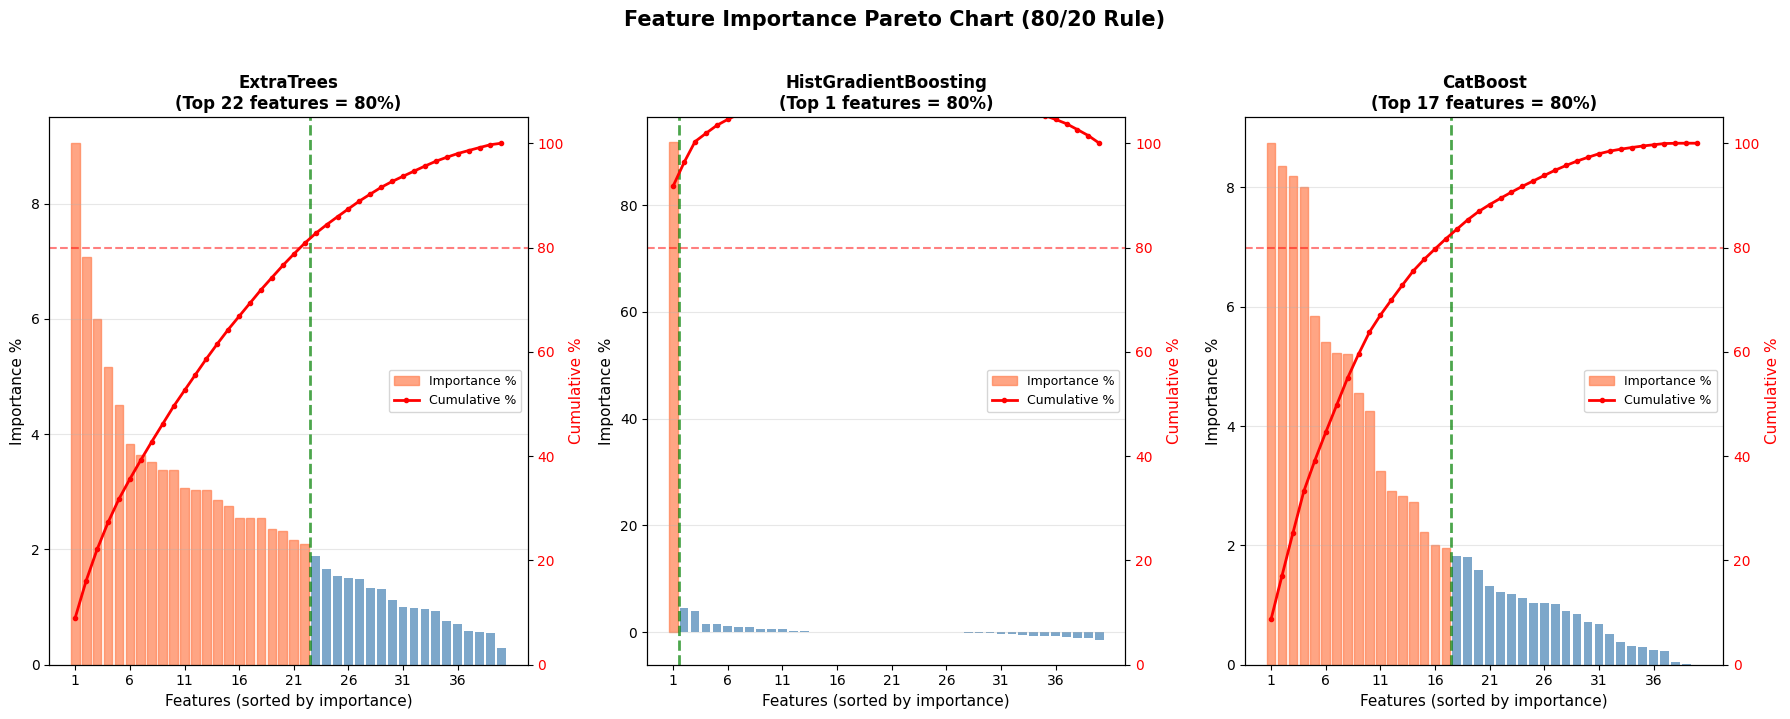


パレートの法則: 80%の重要度に貢献する特徴量

【ExtraTrees】 22/40 特徴量 (55%)
   1. is_rush_period              9.0% (累積:   9.0%)
   2. acc_ma_7                    7.1% (累積:  16.1%)
   3. acc_ma_14                   6.0% (累積:  22.1%)
   4. day_before_holiday_flag     5.2% (累積:  27.3%)
   5. acc_lag_5                   4.5% (累積:  31.8%)
   6. acc_ma_3                    3.8% (累積:  35.6%)
   7. acc_ma_30                   3.6% (累積:  39.3%)
   8. acc_ma_std_14               3.5% (累積:  42.8%)
   9. acc_ma_std_3                3.4% (累積:  46.2%)
  10. acc_lag_1                   3.4% (累積:  49.5%)
  11. acc_ma_std_30               3.1% (累積:  52.6%)
  12. call_num                    3.0% (累積:  55.6%)
  13. acc_lag_7                   3.0% (累積:  58.7%)
  14. cm_14d                      2.9% (累積:  61.5%)
  15. cm_flg                      2.8% (累積:  64.3%)
  16. acc_ma_std_7                2.5% (累積:  66.8%)
  17. call_ma_7                   2.5% (累積:  69.4%)
  18. acc_lag_14                  2.5% (累積:  71.9%)
  19. cm

In [20]:
# ==================================================================================
# 特徴量重要度 パレート図（80/20の法則）
# ==================================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# importance_df が既に存在する前提（cell-19で作成済み）
# なければ以下で読み込み
# importance_df = pd.read_csv(f'{output_dir}/feature_importance.csv')

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

for idx, model_name in enumerate(['ExtraTrees', 'HistGradientBoosting', 'CatBoost']):
    ax = axes[idx]
    
    # 重要度でソート（降順）
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=False).reset_index(drop=True)
    
    # 正規化（合計を100%に）
    total = sorted_df[model_name].sum()
    sorted_df['importance_pct'] = sorted_df[model_name] / total * 100
    sorted_df['cumulative_pct'] = sorted_df['importance_pct'].cumsum()
    
    # 棒グラフ（重要度）
    x = np.arange(len(sorted_df))
    bars = ax.bar(x, sorted_df['importance_pct'], color='steelblue', alpha=0.7, label='Importance %')
    
    # 累積線（パレート曲線）
    ax2 = ax.twinx()
    ax2.plot(x, sorted_df['cumulative_pct'], 'r-o', markersize=3, linewidth=2, label='Cumulative %')
    ax2.axhline(y=80, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax2.set_ylabel('Cumulative %', fontsize=11, color='red')
    ax2.set_ylim(0, 105)
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 80%ラインに達する特徴量数を計算
    n_80 = (sorted_df['cumulative_pct'] <= 80).sum() + 1
    ax.axvline(x=n_80 - 0.5, color='green', linestyle='--', alpha=0.7, linewidth=2)
    
    # 80%に貢献する特徴量をハイライト
    for i in range(min(n_80, len(bars))):
        bars[i].set_color('coral')
    
    ax.set_xlabel('Features (sorted by importance)', fontsize=11)
    ax.set_ylabel('Importance %', fontsize=11)
    ax.set_title(f'{model_name}\n(Top {n_80} features = 80%)', fontsize=12, fontweight='bold')
    ax.set_xticks(x[::5])  # 5個おきにラベル
    ax.set_xticklabels(x[::5] + 1)
    ax.grid(alpha=0.3, axis='y')
    
    # 凡例
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=9)

plt.suptitle('Feature Importance Pareto Chart (80/20 Rule)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance_pareto.png', dpi=300, bbox_inches='tight')
plt.show()

# 80%に貢献するTop特徴量を表示
print("\n" + "=" * 80)
print("パレートの法則: 80%の重要度に貢献する特徴量")
print("=" * 80)

for model_name in ['ExtraTrees', 'HistGradientBoosting', 'CatBoost']:
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=False).reset_index(drop=True)
    total = sorted_df[model_name].sum()
    sorted_df['importance_pct'] = sorted_df[model_name] / total * 100
    sorted_df['cumulative_pct'] = sorted_df['importance_pct'].cumsum()
    
    top_features = sorted_df[sorted_df['cumulative_pct'] <= 80]['feature'].tolist()
    # 80%をちょうど超える特徴量も含める
    if len(top_features) < len(sorted_df):
        top_features.append(sorted_df.iloc[len(top_features)]['feature'])
    
    print(f"\n【{model_name}】 {len(top_features)}/{len(feature_cols)} 特徴量 ({len(top_features)/len(feature_cols)*100:.0f}%)")
    for i, feat in enumerate(top_features, 1):
        pct = sorted_df[sorted_df['feature'] == feat]['importance_pct'].values[0]
        cum = sorted_df[sorted_df['feature'] == feat]['cumulative_pct'].values[0]
        print(f"  {i:2d}. {feat:25s} {pct:5.1f}% (累積: {cum:5.1f}%)")

print(f"\n保存: {output_dir}/feature_importance_pareto.png")
